## Interpreting the output of the feedforward model

In this notebook, we use the [shap](https://github.com/slundberg/shap) library to better understand the patterns the model is learning.

In [1]:
from pathlib import Path
import numpy as np
import json

import shap

import sys
sys.path.insert(0, '..')

from predictor.models import nn_FeedForward
from predictor.preprocessing import VALUE_COLS, VEGETATION_LABELS
from predictor.analysis import plot_shap_values

In [2]:
path_to_arrays = Path('../data/processed/arrays')

In [3]:
with open('../data/processed/normalizing_dict.json', 'r') as f:
    normalizing_dict = json.load(f)

In [4]:
model = nn_FeedForward(path_to_arrays, hide_vegetation=True)

In [5]:
model.train(num_epochs=1)

Training model without vegetation features


  1%|          | 43/8175 [00:00<00:19, 423.90it/s]

After split, training on 261593 examples, validating on 29065 examples


100%|██████████| 909/909 [00:00<00:00, 1515.43it/s]


Epoch 0 - Training RMSE: 0.07138773811884247, Validation RMSE: 0.06969107796896015


In [6]:
model.evaluate()

100%|██████████| 916/916 [00:00<00:00, 1329.30it/s]

Test set RMSE: 0.08441071957349777


Load the tensors for the background and targets

In [7]:
background_data = model.load_tensors(mode='train')

Training model without vegetation features


In [8]:
test_data = model.load_tensors(mode='test')

Shap values will be calculated relative to a background mean, so we want this background to be indicative of what the model might expect if it had no information. We'll calculate this by taking a random sample of the background

In [9]:
num_examples = 500
background_x = background_data.x[np.random.randint(0, background_data.x.shape[0], num_examples)]

Next, lets predict for the first two instances in `test_data`

In [10]:
test_x = test_data.x[:1]
test_true = test_data.y[:1]

In [11]:
print(f'For a true value of {round(test_true.item(), 3)}, the model'
      f'predicted {round(model.model(test_x).item(), 3)}')

For a true value of 0.484, the modelpredicted 0.398


In [12]:
e = shap.DeepExplainer(model.model, background_x)

In [13]:
shap_values = e.shap_values(test_x)

Next, let's denormalize the values so they are more meaningful to us.

In [14]:
values_no_veg = [val for val in VALUE_COLS if val not in VEGETATION_LABELS]

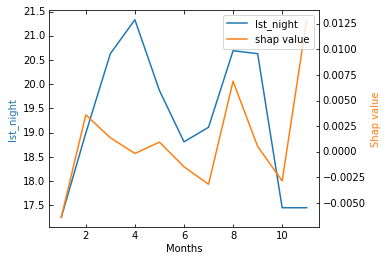

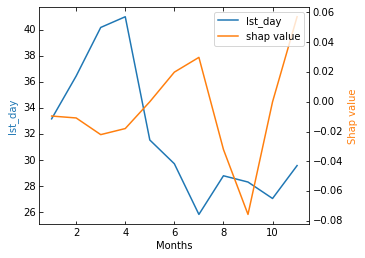

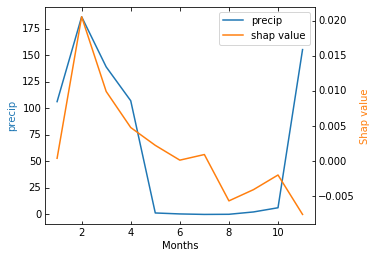

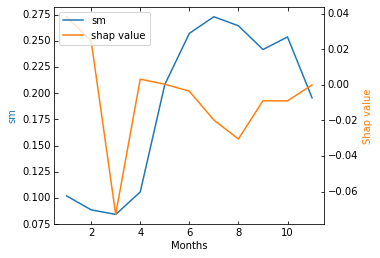

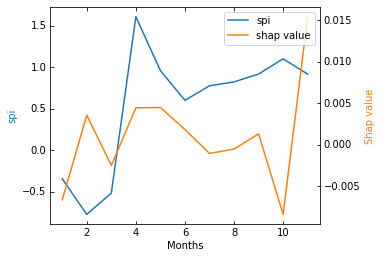

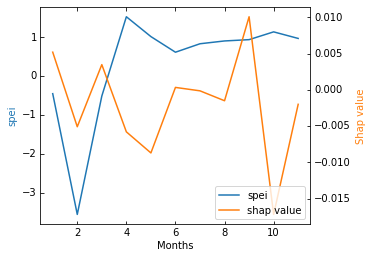

In [15]:
for val in values_no_veg:
    plot_shap_values(test_x[0], shap_values[0], values_no_veg, normalizing_dict, val)